In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [11]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [12]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [14]:
### Your code is here
num_cols = df.select_dtypes(exclude='object').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [ ]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df[num_cols])

In [ ]:
df.describe(include='object')

In [ ]:
df = df.fillna(df.mode().iloc[0])


In [18]:
df.select_dtypes('object').nunique()

Type_of_Cab                     5
Confidence_Life_Style_Index     3
Destination_Type               14
Gender                          2
dtype: int64

In [19]:
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

### Training

In [20]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     test_size=0.2,
                                                     shuffle=True,
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
pipe1 = Pipeline([('scaler', StandardScaler()),
                  ('one_vs_all', OneVsRestClassifier(logit))])

pipe1.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_all',
                 OneVsRestClassifier(estimator=LogisticRegression()))])

In [28]:
from sklearn.metrics import classification_report

print(classification_report(pipe1.predict(X_test), y_test, digits=3))

              precision    recall  f1-score   support

           1      0.542     0.723     0.619      4029
           2      0.834     0.636     0.722     14898
           3      0.571     0.741     0.645      7406

    accuracy                          0.679     26333
   macro avg      0.649     0.700     0.662     26333
weighted avg      0.715     0.679     0.684     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [26]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [27]:
from sklearn.model_selection import GridSearchCV

grid1 = GridSearchCV(pipe1, param_grid, cv=5)
grid1.fit(X_train, y_train)

print(f"Best parameters: {grid1.best_params_}")
print(classification_report(grid1.predict(X_test), y_test, digits=3))



Best parameters: {'one_vs_all__estimator__C': 0.001, 'one_vs_all__estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           1      0.534     0.742     0.621      3868
           2      0.839     0.635     0.723     15010
           3      0.576     0.742     0.649      7455

    accuracy                          0.681     26333
   macro avg      0.650     0.706     0.664     26333
weighted avg      0.720     0.681     0.687     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

In [29]:
grid1.predict_proba(X_test)



array([[0.3062245 , 0.27486411, 0.41891139],
       [0.02308103, 0.5404543 , 0.43646468],
       [0.02306905, 0.55678486, 0.42014609],
       ...,
       [0.48673502, 0.10505849, 0.4082065 ],
       [0.5666375 , 0.18013107, 0.25323143],
       [0.13873848, 0.59998973, 0.26127179]])

In [30]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1))

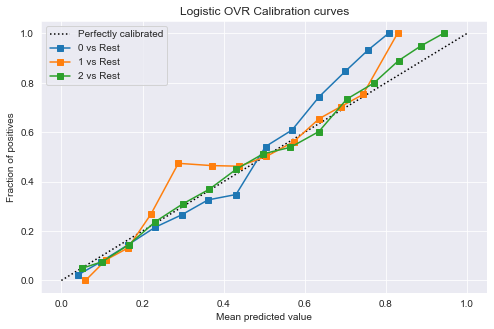

In [31]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Калибровочные кривые
for label in range(3):
    prob_pos = grid1.predict_proba(X_test)[:, label]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_ohe[:, label],
                                                                    prob_pos,
                                                                    n_bins=15)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{label} vs Rest")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title('Logistic OVR Calibration curves')
plt.legend();

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [32]:
### Создание полиномиальных признаков

X_polinomial = X.copy()


for col in num_cols.drop('Surge_Pricing_Type'):
    data_part = pd.concat([X[col]**(1+i) for i in range(4)], axis=1)
    data_part.columns = [col + f"_power_{i+1}" for i in range(4)]

    X_polinomial = X_polinomial.drop(col, axis=1)
    X_polinomial = pd.concat((X_polinomial, data_part), axis=1)

X_polinomial.shape

(131662, 52)

In [33]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [34]:
%%time
logit = LogisticRegression(C=0.001, penalty='l2')
pipe2 = Pipeline([('scaler', StandardScaler()),
                  ('one_vs_all', OneVsRestClassifier(logit))])

pipe2.fit(X_pol_train, y_train)

print(classification_report(pipe2.predict(X_pol_test), y_test, digits=3))



              precision    recall  f1-score   support

           1      0.532     0.748     0.622      3822
           2      0.837     0.636     0.723     14935
           3      0.584     0.741     0.653      7576

    accuracy                          0.682     26333
   macro avg      0.651     0.708     0.666     26333
weighted avg      0.720     0.682     0.688     26333

CPU times: user 13.2 s, sys: 5.85 s, total: 19 s
Wall time: 2.99 s


По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

In [35]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y_test.values.reshape(-1, 1))



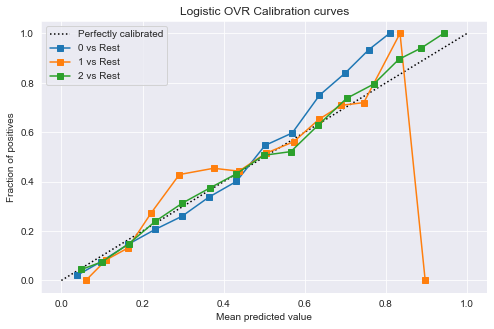

In [36]:
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Калибровочные кривые
for label in range(3):
    prob_pos = pipe2.predict_proba(X_pol_test)[:, label]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_ohe[:, label], prob_pos, n_bins=15)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{label} vs Rest")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.title('Logistic OVR Calibration curves')
plt.legend();

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [37]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

# Обучение
pipe_ovo = Pipeline([('scaler', StandardScaler()),
                     ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])

pipe_ovo.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('one_vs_one', OneVsOneClassifier(estimator=SGDClassifier()))])

In [39]:
print(classification_report(pipe_ovo.predict(X_test), y_test, digits=3))

              precision    recall  f1-score   support

           1      0.521     0.748     0.614      3743
           2      0.870     0.626     0.728     15782
           3      0.536     0.756     0.627      6808

    accuracy                          0.677     26333
   macro avg      0.642     0.710     0.656     26333
weighted avg      0.734     0.677     0.686     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [40]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [41]:
%%time

grid_ovo = GridSearchCV(pipe_ovo, param_grid, cv=5)
grid_ovo.fit(X_train, y_train)

print(f"Best parameters: {grid_ovo.best_params_}")
print(classification_report(grid_ovo.predict(X_test), y_test, digits=3))



Best parameters: {'one_vs_one__estimator__alpha': 0.1, 'one_vs_one__estimator__loss': 'modified_huber', 'one_vs_one__estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           1      0.529     0.748     0.620      3800
           2      0.845     0.633     0.724     15160
           3      0.572     0.745     0.647      7373

    accuracy                          0.681     26333
   macro avg      0.649     0.709     0.663     26333
weighted avg      0.723     0.681     0.687     26333

CPU times: user 1min 27s, sys: 1min 56s, total: 3min 24s
Wall time: 1min


Можно ли однозначной сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?